In [27]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import svm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import seaborn as sns
 


In [117]:

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Note that the test and train data have the same format except the test data doesn't have a survived column.  Test data starts at 892, so lets join these and pre-treat them identically.

In [118]:
all_data = pd.concat([train_data,test_data]).reset_index(drop=True)

## PreProcess data

Missing data?

In [119]:
all_data.apply(lambda x:np.sum(x.isna()))

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Lets forget about Cabin, but we should try to fix Age and Fare by replacing with mean, and Embarked with most common embarked.

In [120]:
all_data.loc[all_data["Age"].isna(),"Age"] =  np.mean(all_data["Age"])
all_data.loc[all_data["Fare"].isna(),"Fare"] =  np.mean(all_data["Fare"])

In [121]:
all_data[["Embarked","PassengerId"]].groupby("Embarked").count()

,PassengerId
Embarked,
C,270
Q,123
S,914


In [122]:
# S is most common:
all_data.loc[all_data["Embarked"].isna(),"Embarked"] =  'S'

In [123]:
all_data["Pclass"] = all_data["Pclass"].astype("category")
all_data.head()
 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [124]:
all_data["AgeCat"] = pd.cut(all_data["Age"],[0,15,29,50,100],
                  labels = ["Child","YoungAdult","MiddleAge","Elder"])

# TOtal family members on board
all_data['Family'] = all_data['Parch']+ all_data['SibSp']

# Maybe being alone matters
all_data['solo'] = all_data['Family'] == 0

# Quantile cut the fare for plotting and other uses
all_data["FareCat"] = pd.qcut(all_data["Fare"],5, labels = ["VL","L","M","H","VH"])

# Age cut was not quantile, but I tried to make it balanced
all_data.groupby("AgeCat")['AgeCat'].count()

AgeCat
Child         115
YoungAdult    454
MiddleAge     645
Elder          95
Name: AgeCat, dtype: int64

In [125]:
# Now split it back out

test_data = all_data[all_data["PassengerId"] >= 892].reset_index(drop=True)

train_data = all_data[all_data["PassengerId"] < 892].reset_index(drop=True)


## Look at the data first

In [126]:
def plot_survival_rate(col):
    survival  = train_data[["Survived",col]].groupby(col).mean().reset_index()
    sns.barplot(data=survival,x=col, y='Survived')

First lets consider Age

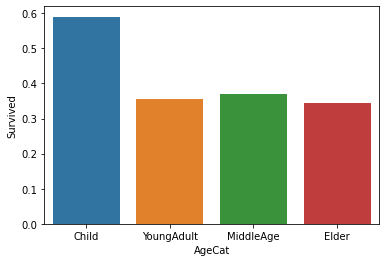

In [127]:
plot_survival_rate("AgeCat")

So age is a predictor of interest.

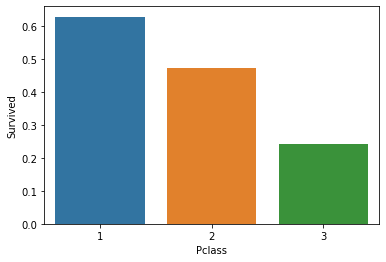

In [128]:
plot_survival_rate('Pclass')

Passenger class certainly matters

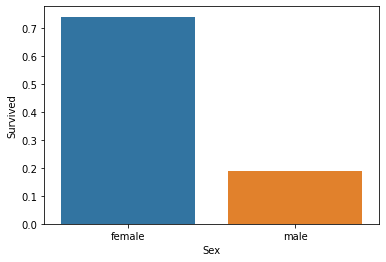

In [129]:
plot_survival_rate('Sex')

As does sex, and as we will see it dominates this... Women and Children First!

In [130]:
train_data[['Sex','Survived','Pclass']].groupby(['Sex','Pclass']).mean()

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

So even controlling for sex, passenger class doesnt matter if we take >50 as survival. 

In [131]:
train_data[['Sex','Survived','AgeCat']].groupby(['Sex','AgeCat']).mean()

Survived
Sex    AgeCat              
female Child       0.651163
       YoungAdult  0.740385
       MiddleAge   0.746667
       Elder       0.941176
male   Child       0.525000
       YoungAdult  0.152284
       MiddleAge   0.177474
       Elder       0.127660

And here we see, the children and women are the ones with > 50 % survival. 

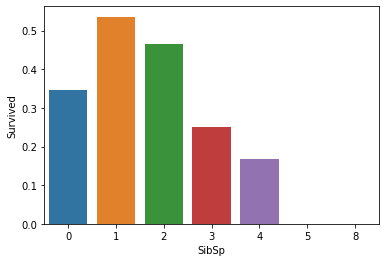

In [132]:
plot_survival_rate('SibSp')

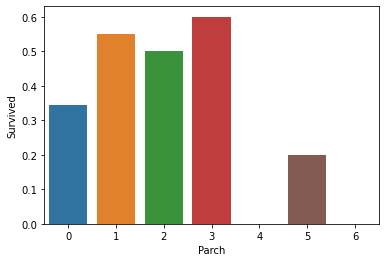

In [133]:
plot_survival_rate('Parch')

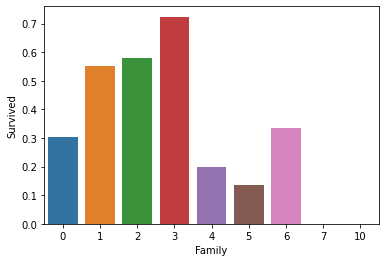

In [135]:
plot_survival_rate('Family')

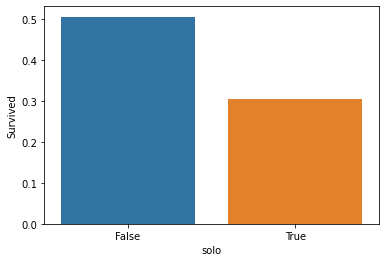

In [136]:
plot_survival_rate('solo')

Solo or Family might help?

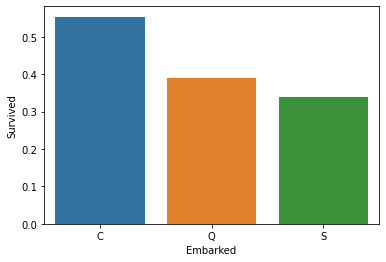

In [134]:
plot_survival_rate('Embarked')

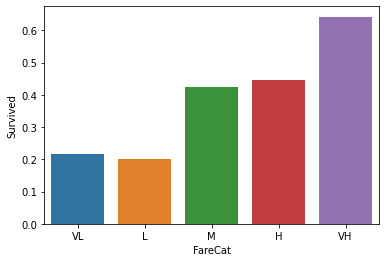

In [12]:

plot_survival_rate('FareCat')

From this we see that Fare is a possible strong predictor, as is class, but these are both highly correlated. We should probably only include one.  

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

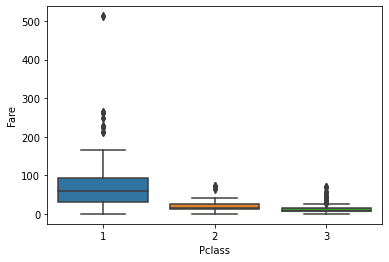

In [13]:
sns.boxplot(x='Pclass', y= 'Fare', data=train_data)

This makes me think that fare has abit  more detail.

<AxesSubplot:xlabel='Age', ylabel='Sex'>

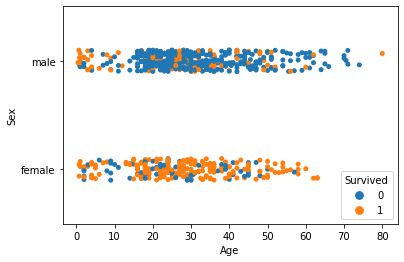

In [14]:
sns.stripplot(x='Age', y='Sex', hue='Survived',data=train_data,jitter=True)

<AxesSubplot:xlabel='Age', ylabel='Fare'>

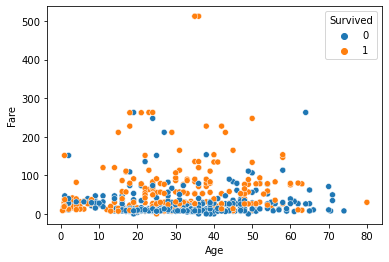

In [15]:
sns.scatterplot(x='Age', y= 'Fare', hue = 'Survived', data = train_data)

## Try to fit a logistic regression

In [137]:
# Zero model
formula0 = "Survived ~ Sex"
mod0 = smf.glm(formula=formula0, data=train_data, family=sm.families.Binomial()).fit()
print(mod0.summary())
np.mean((mod0.predict() > .5) == (train_data["Survived"] ==1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      889
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -458.90
Date:                Thu, 22 Sep 2022   Deviance:                       917.80
Time:                        11:54:31   Pearson chi2:                     891.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2605
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0566      0.129      8.191      

0.7867564534231201

Se We need to do better then 78.7% on teh training data! . Just using Sex does remarkably well as we saw.

This is the best so far using cross validation below. Not stellar by any means

In [138]:
formula1 = "Survived ~ Sex + Family + AgeCat + Pclass + Pclass:Sex + AgeCat:Sex"
mod1 = smf.glm(formula=formula1, data=train_data, family=sm.families.Binomial()).fit()
print(mod1.summary())
score = np.mean((mod1.predict() > .5) == (train_data["Survived"] ==1))
print(f"Score: {score}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      878
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -364.67
Date:                Thu, 22 Sep 2022   Deviance:                       729.35
Time:                        11:54:55   Pearson chi2:                     914.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4015
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## SKlearn

Lets look at cross validation. For this we will use sklearn's tools, so lets make sure it gives same answer for formula1

In [139]:
formula1

'Survived ~ Sex + Family + AgeCat + Pclass + Pclass:Sex + AgeCat:Sex'

In [140]:
outcome, predictors = dmatrices(formula1, train_data, return_type="matrix")
skmod = make_pipeline(StandardScaler(), LogisticRegression())
skmod.fit(predictors, np.ravel(outcome))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [141]:
np.mean(skmod.predict(predictors) == np.ravel(outcome))

array(0.82940516)

Ok so sklearn gets the same results for that formula, now to cross validate. 


## Cross validation

Here i tried various formula and interactions lookign for best cross validaition score.

In [142]:
formulaTest = "Survived ~ Sex + Family + AgeCat + Pclass + Pclass:Sex + AgeCat:Sex"
#formulaTest = "Survived ~ Sex + Family + Age  + I(Age**2) + Pclass + Pclass:Sex + Age:Sex"
outcome, predictors = dmatrices(formulaTest, train_data, return_type="matrix")
scores = cross_val_score(skmod,predictors,np.ravel(outcome),cv=10)
(np.mean(scores),np.std(scores))

(0.8249063670411985, 0.03456312003431916)

Trying out different values of the regulator

In [123]:
formulaTest = "Survived ~ Sex + Family + AgeCat + Pclass + Pclass:Sex + AgeCat:Sex"
outcome, predictors = dmatrices(formulaTest, train_data, return_type="matrix")

def compute_score_reg(penalty, c):
    pipe=make_pipeline(StandardScaler(), LogisticRegression(penalty = penalty, C=c, solver='liblinear'))
    scores = cross_val_score(pipe,predictors,np.ravel(outcome),cv=10)
    return np.mean(scores)




In [124]:
[compute_score_reg("l2",c) for c in [.01,.05,.1,.5,1.0,10.0,100.0]]

[0.7934706616729088,
 0.8058426966292135,
 0.8114481897627964,
 0.8260299625468166,
 0.8249063670411985,
 0.8237952559300874,
 0.8237952559300874]

In [125]:
[compute_score_reg("l1",c) for c in [.01,.05,.1,.5,1.0,10.0,100.0]]

[0.786729088639201,
 0.786729088639201,
 0.8136953807740325,
 0.8249188514357053,
 0.8260299625468164,
 0.8237952559300874,
 0.8237952559300874]

Regularization doesnt seem to help here in any significant way

Also compare 0 model

In [120]:
outcome, predictors = dmatrices(formula0, train_data, return_type="matrix")
scores = cross_val_score(skmod,predictors,np.ravel(outcome),cv=10)
np.mean(scores)

0.786729088639201

So after much struggle, all i get is about 4% gain in CV scores using more then just Sex.

# Apply best model to test data.

In [86]:
np.mean(test_data["Age"])

30.272590361445783

In [143]:
test_data['Survived'] = (mod1.predict(test_data) > 0.5).astype(int)

In [144]:
result = test_data[['PassengerId','Survived']]

In [145]:
result.to_csv('submission.csv',index=False)

In [147]:
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat,Family,solo,FareCat
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,MiddleAge,0,True,VL
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,MiddleAge,1,False,VL
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Elder,0,True,L
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,YoungAdult,0,True,L
4,896,0,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,YoungAdult,2,False,M


# Decision Tree

Looking at the data, it really looks like females and young males are the only ones with > 50% survival, so I suspect a simple decision tree will model this just about as well as teh stuff i have. Lets check it.

In [148]:
clf = tree.DecisionTreeClassifier(max_depth=3)

In [149]:
outcome, predictors = dmatrices('Survived ~ Sex + Age + Fare', train_data, return_type="matrix")
#skmod = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(predictors, np.ravel(outcome))

DecisionTreeClassifier(max_depth=3)

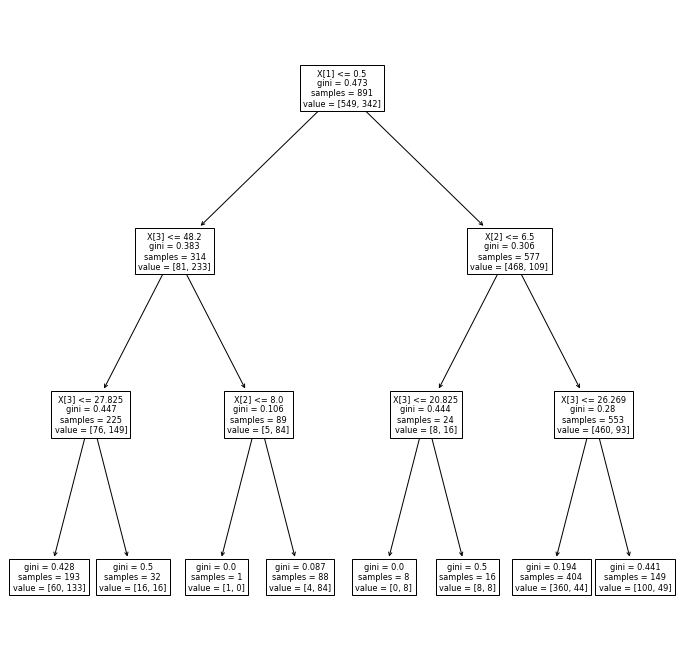

In [150]:
plt.figure(figsize=(12,12)) 
tree.plot_tree(clf);

The story this tree tells is that for Females, the majority survived so we should just predict survival for females. 
For Males, we should predict death, unless  they are very young < 6.5 then we should predict survival .  The tree has a strange feature that it predicts 50/50 for high paying children but there is not a lot of data to really support that.

In [151]:
 
scores = cross_val_score(clf,predictors,np.ravel(outcome),cv=10)
(np.mean(scores),np.std(scores))

(0.7912609238451934, 0.032916213547145814)

Well, this tree doesnt do as well as my logistic regression.  I am sure random forest or other would do better, but the point is my story doesnt really help explain the 4% . Might need those interactions? But I am leaving this for now and on to other things!